# WATER BAG PREDICTION - Preliminar Evaluation

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [2]:
import os, json, pandas as pd, numpy as np, pickle
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Time serie features transformation pipeline & binary classification pipeline (Authoral)
from Modulos.sample_filter import min_max_filter_stats, min_max_filter, filter_by_stats
from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample, groupSplitGridSearch
from Modulos.imbalanced_classification import ClassificationPipeline, classesGroupRecall

#### Preprocessing & machine learning modules
from sklearn.preprocessing import MinMaxScaler as mms
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt
from imblearn.under_sampling import RandomUnderSample
from sklearn.utils import all_estimators
from sklearn.metrics import classification_report as cr
from imblearn import ensemble

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

#### Define metrics and scoring functions
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, precision_recall_fscore_support

recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)
f1_1 = make_scorer(f1_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall', 'precision': 'precision',
    'recall-0': recall_0, 'recall-1': recall_1,
    'precision-0': precision_0, 'precision-1': precision_1,
    'f1-1': f1_1
}

c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Custom functions

In [15]:
def split_report(Y, yt, ye):
    cnts = [yt.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
    print('\nTrain folder'); display(pd.concat(cnts, 1))
    cnts = [ye.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
    print('\nValidation folder'); display(pd.concat(cnts, 1))

    eval_size = len(ye) / len(Y) * 100
    eval_minority = (ye==1).sum() / (Y==1).sum() * 100
    train_minority = (ye==0).sum() / (Y==0).sum() * 100
    eval_stats = pd.DataFrame(
        [eval_size, train_minority, eval_minority],
        ['Samples left', 'Negative Samples left', 'Positive Samples left'],
        ['Validation (%)'],
    ).round(2)
    display(eval_stats)

from sklearn.metrics import precision_recall_curve

def threshold_precision_recall_plot(ye, yprob, threshold):
    curve = pd.DataFrame(
        precision_recall_curve(ye, yprob, pos_label=1),
        index=['precision', 'recall', 'threshold']
    ).T.set_index('threshold').add_suffix(f' - 1')
    curve['f1 - 1'] = curve.mean(1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
    curve.plot(ax=ax)
    if threshold is not None:
        yhat_fix = (yprob > threshold).astype('int')
        scr = pd.DataFrame(cr(ye, yhat_fix, digits=4, output_dict=True)).T
        return ax, scr
    return ax

def classifier_evaluation(model, xt, yt, xe, ye, threshold=None, flat_score=False):
    model.fit(xt, yt)
    try: yprob = pd.Series(model.predict_proba(xe)[:, 1], index=xe.index)
    except: yprob = pd.Series(model.predict(xe), index=xe.index)
    ax = threshold_precision_recall_plot(ye, yprob, threshold=None); plt.show()
    if threshold is None:
        threshold = float(input('Select decision threshold:'))
    yhat = (yprob >= threshold).astype('int')
    scr = pd.DataFrame(
        precision_recall_fscore_support(ye, yhat),
        index=['precision', 'recall', 'f1', 'support']
    ).T; display(scr)
    if flat_score:
        scr = pd.concat([scr.loc[label].add_suffix('-' + str(label)) for label in [0, 1]], 0)
    return scr, threshold

---
## Load & Preprocess Data

In [4]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True)

data = project.data
Yi = project.time_serie
waterbags = project.waterbags

# Sample groups names per group label
target_names = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

---
# Feature and target selection

### Feature set

In [5]:
train_start, train_end = '2018-06', '2021-10'
eval_start, eval_end = '2021-11', '2022-04'
transform_args = dict(
    scale=True, interpolate='nearest', fillna='mean'
)

# Select feature set
X = TimeseriesTransformPipeline(
    data, train_start, cut=-1,
    drop_empty_cols=True,
    **transform_args,
); X = X[: eval_end]

# Validation split
xt = X[:train_end]
xe = X[eval_start: eval_end]

Initial data: (437875, 230)
Time extraction: (142866, 230)
Drop empty columns:  (142865, 217)


### Target variable

In [6]:
target_id = Yi.columns[2]
periods_ahead = 4

print(f'Modeling target {target_names[int(target_id)]} - id: {target_id}', '\n')

# Select target
Y = Yi[str(target_id)].loc[X.index].copy()
display(Y.value_counts().to_frame('Target'))

# Group target positive class labels by being consecutive in time (group evaluation strategy)
groups = groupConsecutiveFlags(ts=Y)

### Target transformation
if periods_ahead is not None:
    Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(-periods_ahead + 1) > 0).astype('float')
    groups = groupConsecutiveFlags(ts=Y)
    display(Y.value_counts().to_frame('Transformed Target'))

# Target validation split
yt = Y.loc[xt.index]
ye = Y.loc[xe.index]
groups_train = groups.loc[xt.index]
groups_eval = groups.loc[xe.index]

### Validation statistics ---

split_report(Y, yt, ye)

Modeling target Rua do Catete - id: 1 



,Target
0.0,136496
1.0,783


,Transformed Target
0.0,136282
1.0,997



Train folder


,Class Count,Class Count
0.0,119037,0.992777
1.0,866,0.007223



Validation folder


,Class Count,Class Count
0.0,17245,0.992461
1.0,131,0.007539


,Validation (%)
Samples left,12.66
Negative Samples left,12.65
Positive Samples left,13.14


### Extra: Filter training data (Optional)

Initial data: (437875, 230)
Time extraction: (142866, 230)
Drop empty columns:  (142865, 217)


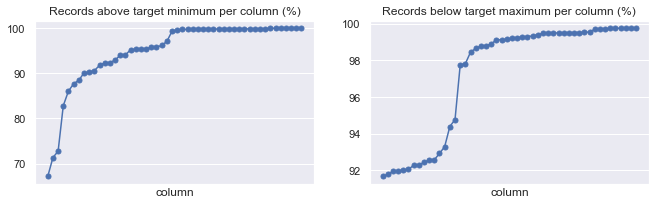

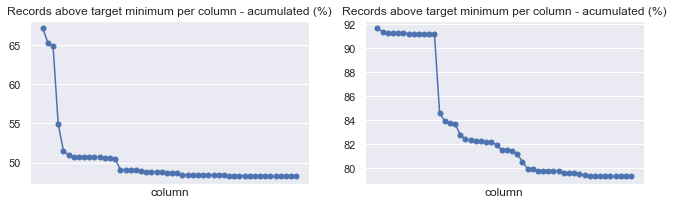

N° of columns to filter by minimum: 5
N° of columns to filter by maximum: 13



Positive minimum filter:

Records: 119903
Records left: 61796
Records left (%): 51.54 %

Positive maximum filter:

Records: 61796
Records left: 54492
Records left (%): 88.18 %



,Class Count,Percent left (%)
0.0,53626,45.05
1.0,866,100.00


In [7]:
# Select raw feature set for preprocessing
X_raw = TimeseriesTransformPipeline( # Must use untransformed data to perform filtering fiter
    data, train_start, cut=-1,
    drop_empty_cols=True, scale=False,
    interpolate=None, fillna=None
); X_raw = X_raw[: eval_end]

### Records left after filtering by columns' minimum thresholds
x_filt, y_filt, groups_filt = filter_by_stats(
    X_raw.loc[xt.index], yt, groups=groups_train,
    n_filters=[None, None], choose_from=50,
    acumulate='and', top_down=True,
    figsize=(11, 3)
); x_filt = xt.loc[x_filt.index].copy()

---
# Base line model evaluation

In [27]:
from sklearn.linear_model import LinearRegression, Lasso

# Select specific classification model
gbc = classifiers['GradientBoostingClassifier']

model = gbc(n_estimators=20, random_state=0)
# model = LinearRegression()

### Evaluate train data on validation period

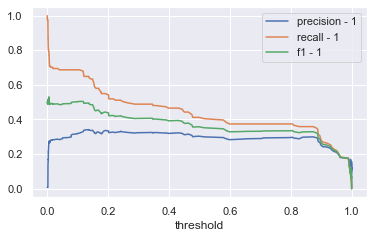

Select decision threshold: .2


,precision,recall,f1,support
0,0.996504,0.991766,0.994129,17245.0
1,0.333333,0.541985,0.412791,131.0


In [28]:
scr, thresh = classifier_evaluation(model, xt, yt, xe, ye)

---
# Undersample evaluation

### Filtered data on validation period

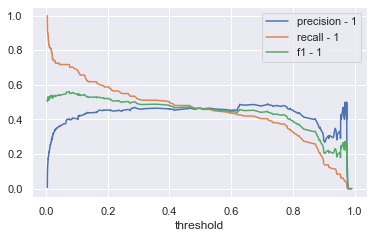

Select decision threshold: .2


,precision,recall,f1,support
0,0.996862,0.994665,0.995762,17245.0
1,0.455621,0.587786,0.513333,131.0


In [29]:
scr, thresh = classifier_evaluation(model, x_filt, y_filt, xe, ye)

### Undersampled data on validation period - Filtered data train class proportion

,Class Count
0.0,53626
1.0,866


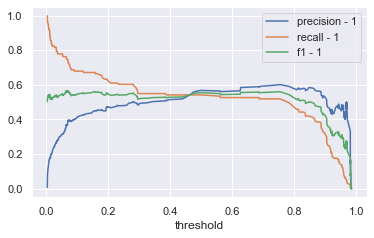

Select decision threshold: .5


,precision,recall,f1,support
0,0.996522,0.996869,0.996695,17245.0
1,0.568000,0.541985,0.554688,131.0


In [31]:
from imblearn.under_sampling import RandomUnderSampler

filt_prct = y_filt.mean() / (1 - y_filt.mean())
rus = RandomUnderSampler(sampling_strategy=filt_prct, random_state=0, replacement=False)

x_res, y_res =  rus.fit_resample(xt, yt)
display(y_res.value_counts().to_frame('Class Count'))

scr_under, thresh = classifier_evaluation(model, x_res, y_res, xe, ye)

### Undersampled data on validation period - Filtered data train class proportion (with replacement)

,Class Count
0.0,53626
1.0,866


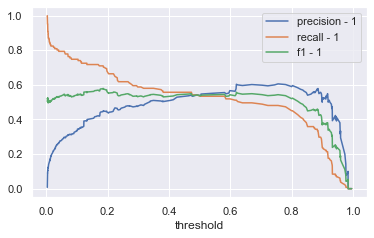

Select decision threshold: .2


,precision,recall,f1,support
0,0.997497,0.993505,0.995497,17245.0
1,0.440000,0.671756,0.531722,131.0


In [30]:
filt_prct = y_filt.mean() / (1 - y_filt.mean())
rus = RandomUnderSampler(sampling_strategy=filt_prct, random_state=0, replacement=True)

x_res, y_res =  rus.fit_resample(xt, yt)
display(y_res.value_counts().to_frame('Class Count'))

scr_under, thresh = classifier_evaluation(model, x_res, y_res, xe, ye)

---
# Cross validation

In [ ]:
splitter = MinorityGroupSplitUndersample(
    n_splits=5,
#     train_size, test_size,               # Not used if minority split strategy is GroupKFold
    train_prct=None, test_prct='natural',  # Natural percentage for por train and test samples
    random_state=0,
)

### Cross-validate train data

In [32]:
cv_train = list(splitter.split(
    xt, yt, groups_train,
    strategy='GroupKFold'
)); print_cls_cnt(yt, cv_train[0][0], cv_train[0][1])

scr_train = pd.DataFrame(cross_validate(
    model, xt, yt, cv=cv_train,
    scoring=scoring, n_jobs=-1,
    verbose=5, error_score='raise'
))

,Train set,Test set
Class,,
0.0,95119,23917
1.0,692,174


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


### Cross-validate train and validation data

In [33]:
cv_test = list(splitter.split(
    X, Y, groups,
    strategy='GroupKFold'
)); print_cls_cnt(Y, cv_test[0][0], cv_test[0][1])

scr_test = pd.DataFrame(cross_validate(
    model, X, Y, cv=cv_test,
    scoring=scoring, n_jobs=-1,
    verbose=5, error_score='raise'
))

,Train set,Test set
Class,,
0.0,109216,27065
1.0,799,198


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


### Compare results

In [34]:
for score in (scr_train, scr_test):
    display(score.describe().loc[['mean', 'std'], ['test_recall-1', 'test_precision-1']])

,test_recall-1,test_precision-1
mean,0.354555,0.676587
std,0.134878,0.055755


,test_recall-1,test_precision-1
mean,0.466742,0.764183
std,0.113788,0.032264


---
# Model deployment

In [ ]:
deploy_info_path = 'API Deploy/deploy_info.csv'
models_path = 'API Deploy/Modelos/'
thresholds_path = 'API Deploy/thresholds.json'

### Deployment information

In [ ]:
# Select raw feature set for preprocessing
X_raw = TimeseriesTransformPipeline( # Must use untransformed data to perform filtering fiter
    data, train_start, cut=-1,
    drop_empty_cols=True, scale=False,
    interpolate=None, fillna=None
); X_raw = X_raw[: eval_end]

# Save Features description
X_info = X_raw.describe().loc[['min', 'max', 'mean']].T
X_info.to_csv(deploy_info_path, index=True)

### Model information

In [63]:
def save_model(model, name, _id, path, score=None):
    model_path = path + name + '/'
    model_file = model_path + 'model_' + name + '-' + _id + '.pickle'
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    pickle.dump(final_model, open(model_file, 'wb'))
    if score is not None:
        score_file = model_path + 'score_' + name + '-' + _id + '.csv'
        score.to_csv(score_file, index=True)
    print('Done! Model saved at:', model_file)

# Write values to json file keys' fields
def update_json_file(obj, path):
    raw_file = json.loads(open(path, 'r').read())
    for key in obj.keys():
        raw_file[key] = obj[key]
    with open(path, 'w') as file:
        file.write(json.dumps(raw_file))

In [ ]:
model_info = {
    'id': target_id,
    'name': target_names[int(target_id)],
    'model': final_model,
    'threshold': threshold,
    'score': final_score,
}

# Save model and score to desired path
save_model(
    final_model, model_info['name'],
    model_info['id'], models_path,
    score=model_info['score']
)

# Write model threshold to json file
update_json_file(
    {model_info['id']: model_info['threshold']},
    path=thresholds_path
)